# Data exploration for feb 23 data

### Problem statement

###### Applications:

1. DFT service (sleep time 1s)
2. FileIO service (sleep time 2s)
3. Broadcast service (sleep time random 10s)
4. Compression service (sleep time 2s)

###### Anomaly:

One of the services on BB9 stops working. Detect the malfunction.

### Notes:

1. Try Gaussian mixture model
2. Fixed window
3. 

### Code:

###### Imports

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plotter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

###### Get data:

In [2]:
cpu_df = pandas.read_csv("data/feb24/feb24_cpu.csv").set_index("Time")
net_tx_df = pandas.read_csv("data/feb24/feb24_network_tx.csv").set_index("Time")
net_rx_df = pandas.read_csv("data/feb24/feb24_network_rx.csv").set_index("Time")
disk_df = pandas.read_csv("data/feb24/feb24_disk_io.csv").set_index("Time")

##### Basic Statistics

In [3]:
#cpu_df.describe()

In [4]:
#net_rx_df.describe()

In [5]:
#net_tx_df.describe()

In [6]:
#disk_df.describe()

### Plots

###### Boxplot CPU usage

In [7]:
%matplotlib 
cpu_df.boxplot()
plotter.show()

Using matplotlib backend: Qt5Agg


##### Boxplot network_tx throughput

In [8]:
%matplotlib 
net_tx_df.boxplot()
plotter.show()

Using matplotlib backend: Qt5Agg


###### Boxplot network_rx throughput

In [9]:
%matplotlib 
net_rx_df.boxplot()
plotter.show()

Using matplotlib backend: Qt5Agg


###### Boxplot disk_io

In [10]:
%matplotlib 
disk_df.boxplot()
plotter.show()

Using matplotlib backend: Qt5Agg


### Observations from visualisation:

1. CPU usage has outliers going up to 50,000 units but most data lies between 0 - 5000
2. network_tx has outliers, most data between 0-200000
3. network_rx should be between 0 - 500000
4. disk usage should be between 0 - 4000

### Preprocessing:

* Clip CPU usage to 5000.

In [7]:
cpu_df = cpu_df.drop("Unnamed: 0", axis=1)
cpu_df = cpu_df.clip(lower=0, upper=5000)

* Clip network_tx to 200000

In [8]:
net_tx_df = net_tx_df.drop("Unnamed: 0", axis=1)
net_tx_df = net_tx_df.clip(lower=0, upper=100000)

* Clip network_rx to 500000

In [9]:
net_rx_df = net_rx_df.drop("Unnamed: 0", axis=1)
net_rx_df = net_rx_df.clip(lower=0, upper=200000)

* Clip disk IO to 4000

In [10]:
disk_df = disk_df.drop("Unnamed: 0", axis=1)
disk_df = disk_df.clip(lower=0, upper=500)

#### Assemble into one dataframe:

In [11]:
df = pandas.concat([cpu_df, net_rx_df, net_tx_df, disk_df], join='inner', axis=1).fillna(0)
del cpu_df
del net_tx_df
del net_rx_df
del disk_df

In [12]:
#df.describe()

In [13]:
#df.head(5)

#### Seperate dataframes per node

In [14]:
def get_dfs(df, nodes=12):
    
    dframes={}
    
    for i in range(1,nodes+1):
        cols=list(filter(lambda x: f"bb{i}l" in x, df.columns))
        dframes[f"BB_{i}"]=df[cols]
        
    return dframes

In [15]:
dframes = get_dfs(df, 12)

### Prepare PCA and clustering

In [16]:
scaler = MinMaxScaler()

In [17]:
print(dframes["BB_1"].shape)
print(dframes["BB_9"].shape)

(33793, 28)
(33793, 28)


In [18]:
data = numpy.vstack([dframes["BB_1"].as_matrix(), dframes["BB_2"].as_matrix()])
data.shape

(67586, 28)

In [19]:
scaler.fit(data)

MinMaxScaler(copy=True, feature_range=(0, 1))

[[ 0.          0.          0.          0.38709677  0.          0.13076923
   0.88704819  0.          0.          0.          0.          0.          0.
   0.          0.49894508  0.51578947  0.          0.          0.          0.
   0.          0.          0.49248802  0.55555556  0.068       0.          0.
   0.068     ]
 [ 0.          0.          0.          0.32258065  0.          0.19230769
   0.84186747  0.          0.          0.          0.          0.          0.
   0.          0.47718368  0.48421053  0.          0.          0.          0.
   0.          0.          0.59754124  0.49206349  0.02266667  0.          0.
   0.02266667]
 [ 0.          0.          0.          0.35483871  0.          0.17115385
   0.85391566  0.          0.          0.          0.          0.          0.
   0.          0.44698294  0.48421053  0.          0.          0.          0.
   0.          0.          0.48290801  0.6031746   0.04133333  0.          0.
   0.04133333]
 [ 0.          0.          0.  

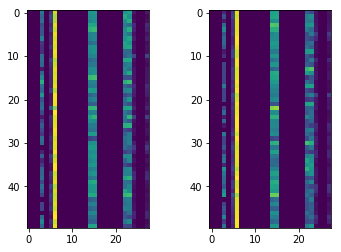

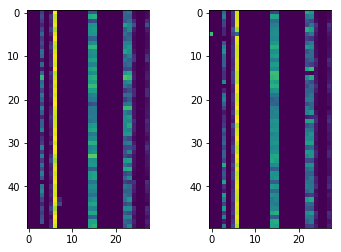

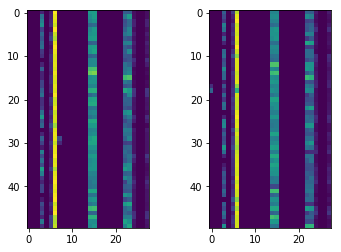

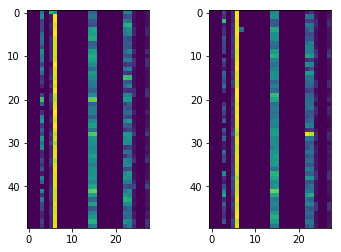

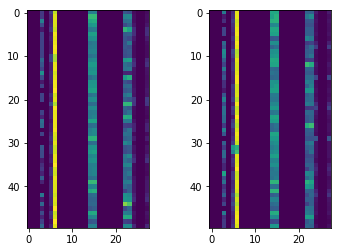

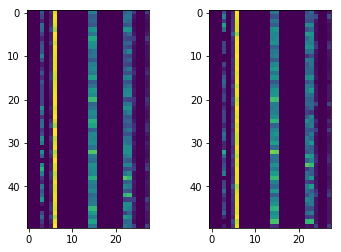

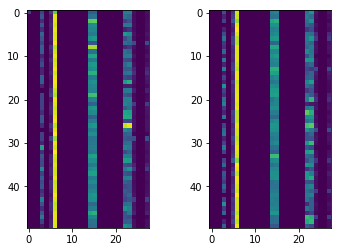

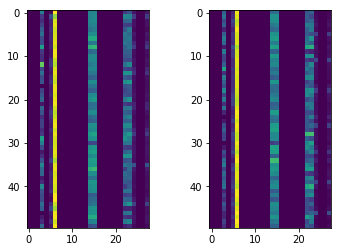

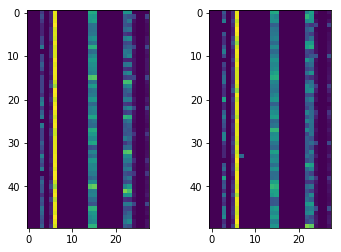

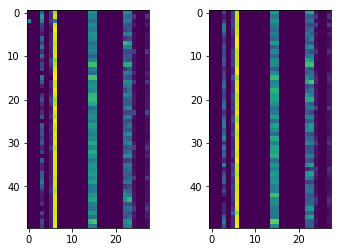

In [20]:
del data
data1s = scaler.transform(dframes["BB_1"][:33500].as_matrix())
data2s = scaler.transform(dframes["BB_2"][:33500].as_matrix())
print(data1s[:5])
print(data2s[:5])
data1s = data1s.reshape((-1,50,28))
data2s = data2s.reshape((-1,50,28))
batch_size = data1s.shape[0]

for i in range(10):
    plotter.subplot(121)
    plotter.imshow(data1s[i])
    plotter.subplot(122)
    plotter.imshow(data2s[i])
    plotter.show()

data1s = data1s.reshape((batch_size,-1))
data2s = data2s.reshape((batch_size,-1))

In [21]:
data1y = numpy.zeros(data1s.shape[0])
data2y = numpy.zeros(data2s.shape[0]) + 1.0
print(data1y)
print(data2y)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [22]:
X = numpy.vstack([data1s, data2s])
y = numpy.hstack([data1y, data2y])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
lrc = LogisticRegression(max_iter=10000, verbose=1)
lrc.fit(X_train, y_train)
lrc.score(X_test, y_test)

[LibLinear]

0.95522388059701491

In [25]:
sgdc = SGDClassifier(max_iter=1000, loss='perceptron', verbose=True)
sgdc.fit(X_train, y_train)
sgdc.score(X_test, y_test)

-- Epoch 1
Norm: 330.29, NNZs: 546, Bias: 27.957483, T: 1072, Avg. loss: 121.593474
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 368.11, NNZs: 549, Bias: 43.962516, T: 2144, Avg. loss: 47.673879
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 360.84, NNZs: 550, Bias: 49.873793, T: 3216, Avg. loss: 26.031587
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 342.69, NNZs: 550, Bias: 56.640248, T: 4288, Avg. loss: 16.263693
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 315.27, NNZs: 550, Bias: 60.261520, T: 5360, Avg. loss: 9.911109
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 291.05, NNZs: 550, Bias: 64.603702, T: 6432, Avg. loss: 6.984634
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 274.70, NNZs: 550, Bias: 65.833579, T: 7504, Avg. loss: 6.026112
Total training time: 0.03 seconds.
-- Epoch 8
Norm: 254.53, NNZs: 550, Bias: 66.946803, T: 8576, Avg. loss: 3.819654
Total training time: 0.03 seconds.
-- Epoch 9
Norm: 239.82, NNZs: 550, Bias: 67.966178, T: 964

Norm: 41.79, NNZs: 550, Bias: 73.731802, T: 155440, Avg. loss: 0.035200
Total training time: 0.40 seconds.
-- Epoch 146
Norm: 41.57, NNZs: 550, Bias: 73.795618, T: 156512, Avg. loss: 0.034741
Total training time: 0.41 seconds.
-- Epoch 147
Norm: 41.60, NNZs: 550, Bias: 73.732393, T: 157584, Avg. loss: 0.063260
Total training time: 0.41 seconds.
-- Epoch 148
Norm: 41.34, NNZs: 550, Bias: 73.795336, T: 158656, Avg. loss: 0.042143
Total training time: 0.41 seconds.
-- Epoch 149
Norm: 41.20, NNZs: 550, Bias: 73.795218, T: 159728, Avg. loss: 0.046982
Total training time: 0.41 seconds.
-- Epoch 150
Norm: 41.18, NNZs: 550, Bias: 73.794996, T: 160800, Avg. loss: 0.067798
Total training time: 0.42 seconds.
-- Epoch 151
Norm: 41.11, NNZs: 550, Bias: 73.794892, T: 161872, Avg. loss: 0.060190
Total training time: 0.42 seconds.
-- Epoch 152
Norm: 40.90, NNZs: 550, Bias: 73.794861, T: 162944, Avg. loss: 0.021367
Total training time: 0.42 seconds.
-- Epoch 153
Norm: 40.77, NNZs: 550, Bias: 73.794768,

Norm: 32.98, NNZs: 550, Bias: 73.559624, T: 237984, Avg. loss: 0.030379
Total training time: 0.60 seconds.
-- Epoch 223
Norm: 32.87, NNZs: 550, Bias: 73.559648, T: 239056, Avg. loss: 0.010476
Total training time: 0.61 seconds.
-- Epoch 224
Norm: 32.75, NNZs: 550, Bias: 73.559654, T: 240128, Avg. loss: 0.005890
Total training time: 0.61 seconds.
-- Epoch 225
Norm: 32.60, NNZs: 550, Bias: 73.559655, T: 241200, Avg. loss: 0.000596
Total training time: 0.61 seconds.
-- Epoch 226
Norm: 32.46, NNZs: 550, Bias: 73.559655, T: 242272, Avg. loss: 0.000000
Total training time: 0.61 seconds.
-- Epoch 227
Norm: 32.32, NNZs: 550, Bias: 73.559655, T: 243344, Avg. loss: 0.000000
Total training time: 0.62 seconds.
-- Epoch 228
Norm: 32.19, NNZs: 550, Bias: 73.559652, T: 244416, Avg. loss: 0.003234
Total training time: 0.62 seconds.
-- Epoch 229
Norm: 32.08, NNZs: 550, Bias: 73.559638, T: 245488, Avg. loss: 0.008597
Total training time: 0.62 seconds.
-- Epoch 230
Norm: 32.01, NNZs: 550, Bias: 73.559615,

Norm: 26.69, NNZs: 550, Bias: 73.275411, T: 320528, Avg. loss: 0.000000
Total training time: 0.80 seconds.
-- Epoch 300
Norm: 26.61, NNZs: 550, Bias: 73.275408, T: 321600, Avg. loss: 0.003058
Total training time: 0.81 seconds.
-- Epoch 301
Norm: 26.56, NNZs: 550, Bias: 73.275384, T: 322672, Avg. loss: 0.008748
Total training time: 0.81 seconds.
-- Epoch 302
Norm: 26.61, NNZs: 550, Bias: 73.244535, T: 323744, Avg. loss: 0.012528
Total training time: 0.81 seconds.
-- Epoch 303
Norm: 26.55, NNZs: 550, Bias: 73.244544, T: 324816, Avg. loss: 0.003733
Total training time: 0.82 seconds.
-- Epoch 304
Norm: 26.46, NNZs: 550, Bias: 73.244544, T: 325888, Avg. loss: 0.000000
Total training time: 0.82 seconds.
-- Epoch 305
Norm: 26.37, NNZs: 550, Bias: 73.244544, T: 326960, Avg. loss: 0.000000
Total training time: 0.82 seconds.
-- Epoch 306
Norm: 26.29, NNZs: 550, Bias: 73.244544, T: 328032, Avg. loss: 0.000000
Total training time: 0.82 seconds.
-- Epoch 307
Norm: 26.20, NNZs: 550, Bias: 73.244544,

Norm: 22.69, NNZs: 550, Bias: 72.998884, T: 405216, Avg. loss: 0.000000
Total training time: 1.01 seconds.
-- Epoch 379
Norm: 22.63, NNZs: 550, Bias: 72.998884, T: 406288, Avg. loss: 0.000000
Total training time: 1.01 seconds.
-- Epoch 380
Norm: 22.57, NNZs: 550, Bias: 72.998884, T: 407360, Avg. loss: 0.000000
Total training time: 1.01 seconds.
-- Epoch 381
Norm: 22.59, NNZs: 550, Bias: 72.974459, T: 408432, Avg. loss: 0.000361
Total training time: 1.01 seconds.
-- Epoch 382
Norm: 22.56, NNZs: 550, Bias: 72.974499, T: 409504, Avg. loss: 0.006247
Total training time: 1.02 seconds.
-- Epoch 383
Norm: 22.43, NNZs: 550, Bias: 72.998802, T: 410576, Avg. loss: 0.001631
Total training time: 1.02 seconds.
-- Epoch 384
Norm: 22.45, NNZs: 550, Bias: 72.974505, T: 411648, Avg. loss: 0.000633
Total training time: 1.02 seconds.
-- Epoch 385
Norm: 22.39, NNZs: 550, Bias: 72.974505, T: 412720, Avg. loss: 0.000000
Total training time: 1.02 seconds.
-- Epoch 386
Norm: 22.34, NNZs: 550, Bias: 72.974505,

Norm: 19.91, NNZs: 550, Bias: 72.774613, T: 487760, Avg. loss: 0.000000
Total training time: 1.21 seconds.
-- Epoch 456
Norm: 19.86, NNZs: 550, Bias: 72.774613, T: 488832, Avg. loss: 0.000000
Total training time: 1.21 seconds.
-- Epoch 457
Norm: 19.82, NNZs: 550, Bias: 72.774613, T: 489904, Avg. loss: 0.000000
Total training time: 1.21 seconds.
-- Epoch 458
Norm: 19.79, NNZs: 550, Bias: 72.774608, T: 490976, Avg. loss: 0.001569
Total training time: 1.21 seconds.
-- Epoch 459
Norm: 19.84, NNZs: 550, Bias: 72.754300, T: 492048, Avg. loss: 0.004559
Total training time: 1.22 seconds.
-- Epoch 460
Norm: 19.80, NNZs: 550, Bias: 72.754300, T: 493120, Avg. loss: 0.000000
Total training time: 1.22 seconds.
-- Epoch 461
Norm: 19.75, NNZs: 550, Bias: 72.754300, T: 494192, Avg. loss: 0.000000
Total training time: 1.22 seconds.
-- Epoch 462
Norm: 19.71, NNZs: 550, Bias: 72.754300, T: 495264, Avg. loss: 0.000000
Total training time: 1.22 seconds.
-- Epoch 463
Norm: 19.67, NNZs: 550, Bias: 72.754300,

-- Epoch 536
Norm: 17.90, NNZs: 550, Bias: 72.567594, T: 574592, Avg. loss: 0.000000
Total training time: 1.41 seconds.
-- Epoch 537
Norm: 17.86, NNZs: 550, Bias: 72.567594, T: 575664, Avg. loss: 0.000000
Total training time: 1.41 seconds.
-- Epoch 538
Norm: 17.83, NNZs: 550, Bias: 72.567594, T: 576736, Avg. loss: 0.000000
Total training time: 1.41 seconds.
-- Epoch 539
Norm: 17.80, NNZs: 550, Bias: 72.567594, T: 577808, Avg. loss: 0.000000
Total training time: 1.42 seconds.
-- Epoch 540
Norm: 17.76, NNZs: 550, Bias: 72.567594, T: 578880, Avg. loss: 0.000000
Total training time: 1.42 seconds.
-- Epoch 541
Norm: 17.74, NNZs: 550, Bias: 72.567588, T: 579952, Avg. loss: 0.002279
Total training time: 1.42 seconds.
-- Epoch 542
Norm: 17.79, NNZs: 550, Bias: 72.550381, T: 581024, Avg. loss: 0.002246
Total training time: 1.42 seconds.
-- Epoch 543
Norm: 17.76, NNZs: 550, Bias: 72.550381, T: 582096, Avg. loss: 0.000000
Total training time: 1.43 seconds.
-- Epoch 544
Norm: 17.73, NNZs: 550, Bia

Norm: 16.44, NNZs: 550, Bias: 72.389957, T: 661424, Avg. loss: 0.000000
Total training time: 1.61 seconds.
-- Epoch 618
Norm: 16.41, NNZs: 550, Bias: 72.389957, T: 662496, Avg. loss: 0.000000
Total training time: 1.61 seconds.
-- Epoch 619
Norm: 16.39, NNZs: 550, Bias: 72.389957, T: 663568, Avg. loss: 0.000000
Total training time: 1.62 seconds.
-- Epoch 620
Norm: 16.36, NNZs: 550, Bias: 72.389957, T: 664640, Avg. loss: 0.000000
Total training time: 1.62 seconds.
-- Epoch 621
Norm: 16.34, NNZs: 550, Bias: 72.389957, T: 665712, Avg. loss: 0.000000
Total training time: 1.62 seconds.
-- Epoch 622
Norm: 16.31, NNZs: 550, Bias: 72.389957, T: 666784, Avg. loss: 0.000071
Total training time: 1.63 seconds.
-- Epoch 623
Norm: 16.36, NNZs: 550, Bias: 72.374999, T: 667856, Avg. loss: 0.002225
Total training time: 1.63 seconds.
-- Epoch 624
Norm: 16.34, NNZs: 550, Bias: 72.375000, T: 668928, Avg. loss: 0.001396
Total training time: 1.63 seconds.
-- Epoch 625
Norm: 16.31, NNZs: 550, Bias: 72.375000,

Norm: 15.42, NNZs: 550, Bias: 72.261269, T: 737536, Avg. loss: 0.000000
Total training time: 1.81 seconds.
-- Epoch 689
Norm: 15.40, NNZs: 550, Bias: 72.261268, T: 738608, Avg. loss: 0.001053
Total training time: 1.82 seconds.
-- Epoch 690
Norm: 15.39, NNZs: 550, Bias: 72.261253, T: 739680, Avg. loss: 0.001253
Total training time: 1.82 seconds.
-- Epoch 691
Norm: 15.43, NNZs: 550, Bias: 72.247753, T: 740752, Avg. loss: 0.000856
Total training time: 1.82 seconds.
-- Epoch 692
Norm: 15.41, NNZs: 550, Bias: 72.247753, T: 741824, Avg. loss: 0.000000
Total training time: 1.83 seconds.
-- Epoch 693
Norm: 15.39, NNZs: 550, Bias: 72.247753, T: 742896, Avg. loss: 0.000000
Total training time: 1.83 seconds.
-- Epoch 694
Norm: 15.36, NNZs: 550, Bias: 72.247753, T: 743968, Avg. loss: 0.000000
Total training time: 1.83 seconds.
-- Epoch 695
Norm: 15.34, NNZs: 550, Bias: 72.247753, T: 745040, Avg. loss: 0.000000
Total training time: 1.83 seconds.
-- Epoch 696
Norm: 15.32, NNZs: 550, Bias: 72.247753,

Norm: 14.62, NNZs: 550, Bias: 72.120199, T: 821152, Avg. loss: 0.000494
Total training time: 2.02 seconds.
-- Epoch 767
Norm: 14.60, NNZs: 550, Bias: 72.120199, T: 822224, Avg. loss: 0.000000
Total training time: 2.02 seconds.
-- Epoch 768
Norm: 14.58, NNZs: 550, Bias: 72.120199, T: 823296, Avg. loss: 0.000000
Total training time: 2.02 seconds.
-- Epoch 769
Norm: 14.56, NNZs: 550, Bias: 72.120199, T: 824368, Avg. loss: 0.000000
Total training time: 2.02 seconds.
-- Epoch 770
Norm: 14.55, NNZs: 550, Bias: 72.120199, T: 825440, Avg. loss: 0.000000
Total training time: 2.03 seconds.
-- Epoch 771
Norm: 14.53, NNZs: 550, Bias: 72.120199, T: 826512, Avg. loss: 0.000220
Total training time: 2.03 seconds.
-- Epoch 772
Norm: 14.58, NNZs: 550, Bias: 72.108122, T: 827584, Avg. loss: 0.001640
Total training time: 2.03 seconds.
-- Epoch 773
Norm: 14.56, NNZs: 550, Bias: 72.108122, T: 828656, Avg. loss: 0.000392
Total training time: 2.03 seconds.
-- Epoch 774
Norm: 14.54, NNZs: 550, Bias: 72.108122,

Norm: 13.96, NNZs: 550, Bias: 72.004359, T: 902624, Avg. loss: 0.000000
Total training time: 2.22 seconds.
-- Epoch 843
Norm: 13.94, NNZs: 550, Bias: 72.004359, T: 903696, Avg. loss: 0.000000
Total training time: 2.22 seconds.
-- Epoch 844
Norm: 13.92, NNZs: 550, Bias: 72.004359, T: 904768, Avg. loss: 0.000000
Total training time: 2.22 seconds.
-- Epoch 845
Norm: 13.91, NNZs: 550, Bias: 72.004359, T: 905840, Avg. loss: 0.000143
Total training time: 2.22 seconds.
-- Epoch 846
Norm: 13.95, NNZs: 550, Bias: 71.993337, T: 906912, Avg. loss: 0.001414
Total training time: 2.23 seconds.
-- Epoch 847
Norm: 13.94, NNZs: 550, Bias: 71.993337, T: 907984, Avg. loss: 0.000000
Total training time: 2.23 seconds.
-- Epoch 848
Norm: 13.92, NNZs: 550, Bias: 71.993337, T: 909056, Avg. loss: 0.000000
Total training time: 2.23 seconds.
-- Epoch 849
Norm: 13.91, NNZs: 550, Bias: 71.993337, T: 910128, Avg. loss: 0.000000
Total training time: 2.24 seconds.
-- Epoch 850
Norm: 13.89, NNZs: 550, Bias: 71.993337,

Norm: 13.41, NNZs: 550, Bias: 71.888197, T: 988384, Avg. loss: 0.000000
Total training time: 2.42 seconds.
-- Epoch 923
Norm: 13.39, NNZs: 550, Bias: 71.888197, T: 989456, Avg. loss: 0.000000
Total training time: 2.42 seconds.
-- Epoch 924
Norm: 13.38, NNZs: 550, Bias: 71.888197, T: 990528, Avg. loss: 0.000000
Total training time: 2.42 seconds.
-- Epoch 925
Norm: 13.36, NNZs: 550, Bias: 71.888197, T: 991600, Avg. loss: 0.000000
Total training time: 2.42 seconds.
-- Epoch 926
Norm: 13.35, NNZs: 550, Bias: 71.888197, T: 992672, Avg. loss: 0.000000
Total training time: 2.43 seconds.
-- Epoch 927
Norm: 13.34, NNZs: 550, Bias: 71.888196, T: 993744, Avg. loss: 0.000419
Total training time: 2.43 seconds.
-- Epoch 928
Norm: 13.39, NNZs: 550, Bias: 71.878146, T: 994816, Avg. loss: 0.001550
Total training time: 2.43 seconds.
-- Epoch 929
Norm: 13.37, NNZs: 550, Bias: 71.878146, T: 995888, Avg. loss: 0.000066
Total training time: 2.44 seconds.
-- Epoch 930
Norm: 13.36, NNZs: 550, Bias: 71.878146,

Norm: 12.96, NNZs: 550, Bias: 71.791117, T: 1069856, Avg. loss: 0.000000
Total training time: 2.62 seconds.
-- Epoch 999
Norm: 12.95, NNZs: 550, Bias: 71.791117, T: 1070928, Avg. loss: 0.000000
Total training time: 2.62 seconds.
-- Epoch 1000
Norm: 12.94, NNZs: 550, Bias: 71.791116, T: 1072000, Avg. loss: 0.000177
Total training time: 2.63 seconds.


0.92537313432835822

In [26]:
mlpc = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,50), solver='adam', verbose=1, early_stopping=False)
mlpc.fit(X_train, y_train)
mlpc.score(X_test, y_test)

Iteration 1, loss = 0.70480047
Iteration 2, loss = 0.68013495
Iteration 3, loss = 0.67094970
Iteration 4, loss = 0.66231010
Iteration 5, loss = 0.64937210
Iteration 6, loss = 0.62875912
Iteration 7, loss = 0.61535495
Iteration 8, loss = 0.61311147
Iteration 9, loss = 0.58361831
Iteration 10, loss = 0.55400043
Iteration 11, loss = 0.52612706
Iteration 12, loss = 0.49527043
Iteration 13, loss = 0.46375199
Iteration 14, loss = 0.43278795
Iteration 15, loss = 0.42136403
Iteration 16, loss = 0.38490839
Iteration 17, loss = 0.38682598
Iteration 18, loss = 0.38989766
Iteration 19, loss = 0.32862027
Iteration 20, loss = 0.29329793
Iteration 21, loss = 0.27741157
Iteration 22, loss = 0.27859210
Iteration 23, loss = 0.26289093
Iteration 24, loss = 0.24113409
Iteration 25, loss = 0.22356191
Iteration 26, loss = 0.20480946
Iteration 27, loss = 0.20354845
Iteration 28, loss = 0.18991554
Iteration 29, loss = 0.18264939
Iteration 30, loss = 0.17639047
Iteration 31, loss = 0.17101905
Iteration 32, los

0.93656716417910446

## Visualisation

In [27]:
print(data1s.shape)
print(data2s.shape)

(670, 1400)
(670, 1400)


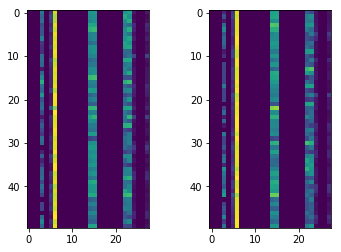

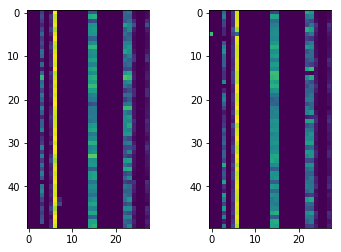

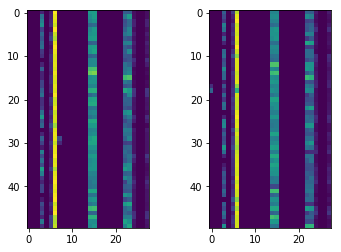

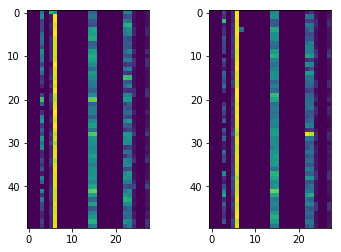

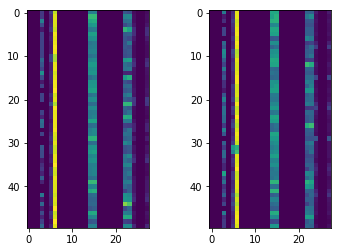

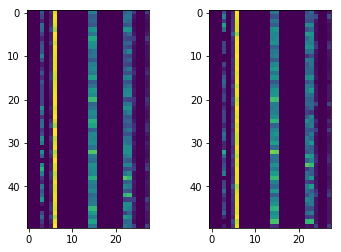

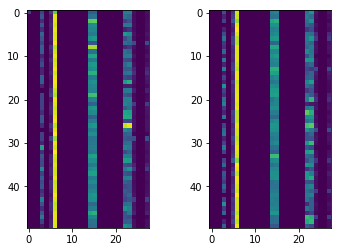

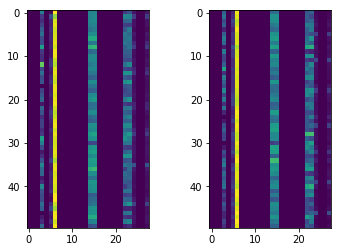

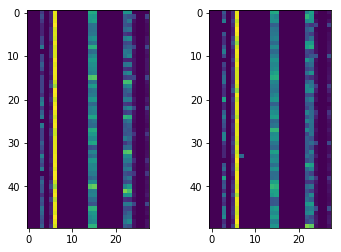

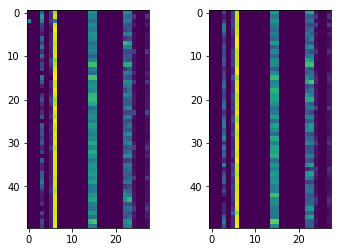

In [28]:
data1s = data1s.reshape((-1,50,28))
data2s = data2s.reshape((-1,50,28))

for i in range(10):
    plotter.subplot(121)
    plotter.imshow(data1s[i])
    plotter.subplot(122)
    plotter.imshow(data2s[i])
    plotter.show()